In [1]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
sys.path.append('/home/UCSD/cobra_utils')
from collections import defaultdict
import pickle

# third party imports
import pandas
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
print(cobra.__file__)
print(cobrame.__file__)
print(bacillusme.__file__)
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/sbml3.py:24: UserWarning: Install lxml for faster SBML I/O
  warn("Install lxml for faster SBML I/O")
/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/io/__init__.py:12: UserWarning: cobra.io.sbml requires libsbml
  warn("cobra.io.sbml requires libsbml")


/home/jt/me_modeling/lib/python3.6/site-packages/cobra-0.5.11-py3.6-linux-x86_64.egg/cobra/__init__.py
/home/jt/UCSD/cobrame/cobrame/__init__.py
/home/jt/UCSD/bacillusme-master/bacillusme/__init__.py


In [2]:
def add_transport_to_model(model,mets):
    for met in mets:
        rxn = cobrame.MEReaction('{}_transport'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            '{}_c'.format(met):-1,
            '{}_s'.format(met):1
        })
        rxn.bounds = (-1000,1000)
        print(rxn.reaction)
def add_sinks_to_model(model,mets):
    rlist = []
    for met in mets:
        rxn = cobrame.MEReaction('SK_{}'.format(met))
        model.add_reactions([rxn])
        rxn.add_metabolites({
            met:1
        })
        rxn.bounds = (0,1e-15)
        rlist.append(rxn)
    return rlist

## Setup

In [3]:
with open("./sporeme_solution_v4_proteomics_spoAQ_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [4]:
add_transport_to_model(sporeme,['utp','ctp','gtp'])

utp_c <=> utp_s
ctp_c <=> ctp_s
gtp_c <=> gtp_s


In [5]:
genes = [i + '_s' for i in list(pd.read_csv('confirmed_depletion_neighborhood_spoAQ.txt',header=None)[1].values)]

In [6]:
cplxs = []
for i in genes:
    m = sporeme.metabolites.get_by_id('protein_'+i)
#     c = find_complex(m)
    cplxs.append(m)
cplxs = set(cplxs)
cplxs

{<TranslatedGene protein_BSU00510_s at 0x7f7b175e5f98>,
 <TranslatedGene protein_BSU00680_s at 0x7f7b1757dcc0>,
 <TranslatedGene protein_BSU00980_s at 0x7f7b17562588>,
 <TranslatedGene protein_BSU01370_s at 0x7f7b17464550>,
 <TranslatedGene protein_BSU07840_s at 0x7f7b171b7128>,
 <TranslatedGene protein_BSU08820_s at 0x7f7b1717f048>,
 <TranslatedGene protein_BSU15320_s at 0x7f7b16f04320>,
 <TranslatedGene protein_BSU15680_s at 0x7f7b16e784e0>,
 <TranslatedGene protein_BSU16090_s at 0x7f7b16dfb278>,
 <TranslatedGene protein_BSU16100_s at 0x7f7b16dfb630>,
 <TranslatedGene protein_BSU16670_s at 0x7f7b16dd5b70>,
 <TranslatedGene protein_BSU18000_s at 0x7f7b16d0c828>,
 <TranslatedGene protein_BSU21770_s at 0x7f7b16c5d2b0>,
 <TranslatedGene protein_BSU21870_s at 0x7f7b16bf4400>,
 <TranslatedGene protein_BSU23500_s at 0x7f7b16ac33c8>,
 <TranslatedGene protein_BSU23860_s at 0x7f7b16a88208>,
 <TranslatedGene protein_BSU24080_s at 0x7f7b16a36630>,
 <TranslatedGene protein_BSU24150_s at 0x7f7b16a

In [7]:
rlist = add_sinks_to_model(sporeme,cplxs)
[(r.id,r.reaction) for r in rlist]

[('SK_protein_BSU18000_s', ' --> protein_BSU18000_s'),
 ('SK_protein_BSU08820_s', ' --> protein_BSU08820_s'),
 ('SK_protein_BSU27850_s', ' --> protein_BSU27850_s'),
 ('SK_protein_BSU28540_s', ' --> protein_BSU28540_s'),
 ('SK_protein_BSU00510_s', ' --> protein_BSU00510_s'),
 ('SK_protein_BSU07840_s', ' --> protein_BSU07840_s'),
 ('SK_protein_BSU38980_s', ' --> protein_BSU38980_s'),
 ('SK_protein_BSU33920_s', ' --> protein_BSU33920_s'),
 ('SK_protein_BSU33940_s', ' --> protein_BSU33940_s'),
 ('SK_protein_BSU23860_s', ' --> protein_BSU23860_s'),
 ('SK_protein_BSU32830_s', ' --> protein_BSU32830_s'),
 ('SK_protein_BSU27870_s', ' --> protein_BSU27870_s'),
 ('SK_protein_BSU36920_s', ' --> protein_BSU36920_s'),
 ('SK_protein_BSU24170_s', ' --> protein_BSU24170_s'),
 ('SK_protein_BSU16090_s', ' --> protein_BSU16090_s'),
 ('SK_protein_BSU37170_s', ' --> protein_BSU37170_s'),
 ('SK_protein_BSU21770_s', ' --> protein_BSU21770_s'),
 ('SK_protein_BSU15320_s', ' --> protein_BSU15320_s'),
 ('SK_prot

In [8]:
sporeme.objective = rlist

In [9]:
from bacillusme.analysis import sensitivity as ss

In [10]:
solve_me_model(sporeme,
               max_mu = 0.1,
               min_mu = .01,
               using_soplex=False,
               precision = 1e-6,
               growth_key = 'sigma',
               verbosity=2)

iter	muopt    	a     	b     	mu1       	stat1
Finished compiling expressions in 232.827374 seconds
Finished substituting S,lb,ub in 6.701090 seconds
Finished makeME_LP in 1.454726 seconds
Getting MINOS parameters from ME_NLP...
1 0.0 0.0 0.05 0.05 1
Finished substituting S,lb,ub in 6.574644 seconds
Finished makeME_LP in 1.276718 seconds
Getting MINOS parameters from ME_NLP...
2 0.025 0.025 0.05 0.025 optimal
Finished substituting S,lb,ub in 7.370161 seconds
Finished makeME_LP in 1.267957 seconds
Getting MINOS parameters from ME_NLP...
3 0.037500000000000006 0.037500000000000006 0.05 0.037500000000000006 optimal
Finished substituting S,lb,ub in 6.283246 seconds
Finished makeME_LP in 1.270787 seconds
Getting MINOS parameters from ME_NLP...
4 0.043750000000000004 0.043750000000000004 0.05 0.043750000000000004 optimal
Finished substituting S,lb,ub in 6.266011 seconds
Finished makeME_LP in 1.264017 seconds
Getting MINOS parameters from ME_NLP...
5 0.046875 0.046875 0.05 0.046875 optimal
Fin

In [11]:
pd.DataFrame.from_dict({'flux':sporeme.solution.x_dict}).T[[r.id for r in rlist]].T.sort_values('flux').value_counts()

flux        
1.000000e-15    38
dtype: int64

## Analysis

In [12]:
flux_responses = ss.all_flux_responses(sporeme,genes,NP=10,precision=1e-6,solution=sporeme.solution,
                       single_change_function='knockout_protein_sink',growth_key='sigma')
flux_responses.to_csv('essentiality_raw_results_neighborhood_spoAQ.csv')

SK_protein_BSU18000_s response (10 threads): 100%|██████████| 38/38 [3:30:40<00:00, 332.64s/it]  


In [13]:
flux_responses.loc[[r.id for r in rlist]]

,base,BSU33040_s,BSU37170_s,BSU23500_s,BSU36010_s,BSU32840_s,BSU24080_s,BSU01370_s,BSU28540_s,BSU32830_s,...,BSU38990_s,BSU36920_s,BSU38980_s,BSU16100_s,BSU16090_s,BSU00980_s,BSU33920_s,BSU15320_s,BSU07840_s,BSU32680_s
SK_protein_BSU18000_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,-8.376984e-28
SK_protein_BSU08820_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU27850_s,1.000000e-15,7.629821e-16,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,0.000000e+00
SK_protein_BSU28540_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,0.000000e+00,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU00510_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU07840_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,0.000000e+00,1.000000e-15
SK_protein_BSU38980_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,0.000000e+00,1.000000e-15,0.000000e+00,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU33920_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,0.000000e+00,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU33940_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15
SK_protein_BSU23860_s,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,...,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15,1.000000e-15


### Gene interdependence

In [14]:
with open("./sporeme_solution_v4_naive.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [15]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [16]:
import pandas as pd
df = pd.read_csv('essentiality_raw_results_neighborhood_spoAQ.csv',index_col=0)

In [17]:
cutoff = 1e-16
translation = df.loc[[r.id for r in rlist]]
active_base = translation[translation['base']>cutoff].T.drop('base')
inactive_base = translation[translation['base']<=cutoff].T.drop('base')

In [18]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('SK_protein_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### Known depletions

In [19]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

## Forward interdependence

In [20]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in fwd_name_dep:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        if 'nadD' in (i,j):
            continue
        G.add_edge(i,j)

In [21]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

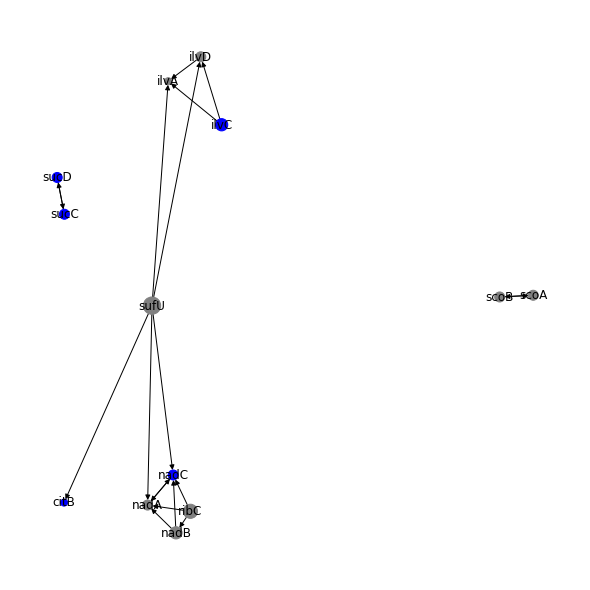

In [22]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=1e-5)
nx.draw(G,
#        pos=pos,
       with_labels = True,
       node_size=[i*50 for i in degree],
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport_neighborhood.svg',format='SVG')

#### Are any of the nodes essential in the FS?

In [23]:
summary = pd.read_csv('./essentiality_summary.csv',index_col=1)
summary.loc[[i for i in G.nodes if i in summary.index]]['FS_essential'].value_counts()

False    12
True      1
Name: FS_essential, dtype: int64

## Subgraphs

In [24]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [25]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 9 has 2 nodes
	Nodes: ['sucC', 'sucD']
subgraph 34 has 3 nodes
	Nodes: ['ilvC', 'ilvA', 'ilvD']
subgraph 62 has 2 nodes
	Nodes: ['sufU', 'citB']
subgraph 80 has 5 nodes
	Nodes: ['sufU', 'nadC', 'nadA', 'ribC', 'nadB']
subgraph 86 has 2 nodes
	Nodes: ['sucC', 'sucD']


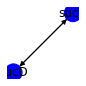

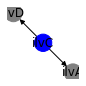

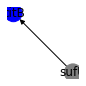

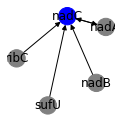

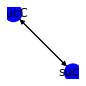

In [26]:
for i, gene in enumerate(set(known_depletions)):
    SG = get_graph_from_gene(gene)
    if len(SG.nodes) == 0:continue
    print ("subgraph {} has {} nodes".format(i, len(SG.nodes)))
    print ("\tNodes:", SG.nodes)
    
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(1.5,1.5))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=1.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
#     plt.savefig('figures/network_neighbor_sg_{}_spoAQ.svg'.format(i),format='SVG')

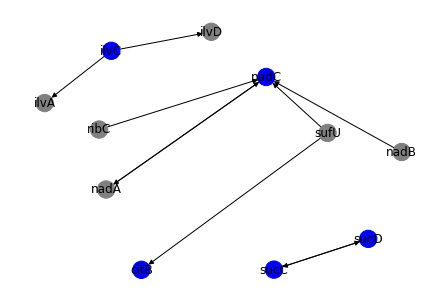

In [27]:
G = nx.DiGraph()

edges = set()
for i, gene in enumerate(set(known_depletions)):
    edges = edges | get_edges_from_gene(gene)

for i,j in edges:
    G.add_edge(i,j)
    
pos = nx.spring_layout(G, k=2.0)
color_map,degree,labels = get_color_map(G)

nx.draw(G,
       pos=pos,
       with_labels = True,
#        node_size=[i*50 for i in degree],
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
#     plt.savefig('figures/network_neighbor_sg_{}_spoAQ.svg'.format(i),format='SVG')

In [28]:
for i in G.edges:
    print(i)

('sufU', 'citB')
('sufU', 'nadC')
('nadC', 'nadA')
('sucC', 'sucD')
('sucD', 'sucC')
('nadA', 'nadC')
('ribC', 'nadC')
('ilvC', 'ilvA')
('ilvC', 'ilvD')
('nadB', 'nadC')


In [180]:
i = name_to_locus['nadD']
j = name_to_locus['acdA']
df['{}_s'.format(i)]['SK_protein_{}_s'.format(j)]

0.0

In [181]:
i,j

('BSU25640', 'BSU37170')

In [159]:
df[df.index.str.contains('SK_prot')]['{}_s'.format(i)]

SK_protein_BSU24080_s    0.0
SK_protein_BSU16100_s    0.0
SK_protein_BSU38990_s    0.0
SK_protein_BSU36010_s    0.0
SK_protein_BSU32840_s    0.0
SK_protein_BSU00510_s    0.0
SK_protein_BSU27250_s    0.0
SK_protein_BSU32680_s    0.0
SK_protein_BSU18000_s    0.0
SK_protein_BSU08820_s    0.0
SK_protein_BSU27850_s    0.0
SK_protein_BSU28540_s    0.0
SK_protein_BSU07840_s    0.0
SK_protein_BSU38980_s    0.0
SK_protein_BSU33920_s    0.0
SK_protein_BSU33940_s    0.0
SK_protein_BSU23860_s    0.0
SK_protein_BSU32830_s    0.0
SK_protein_BSU27870_s    0.0
SK_protein_BSU36920_s    0.0
SK_protein_BSU24170_s    0.0
SK_protein_BSU16090_s    0.0
SK_protein_BSU37170_s    0.0
SK_protein_BSU21770_s    0.0
SK_protein_BSU15320_s    0.0
SK_protein_BSU25290_s    0.0
SK_protein_BSU25640_s    0.0
SK_protein_BSU28290_s    0.0
SK_protein_BSU16670_s    0.0
SK_protein_BSU23500_s    0.0
SK_protein_BSU29120_s    0.0
SK_protein_BSU21870_s    0.0
SK_protein_BSU24150_s    0.0
SK_protein_BSU00680_s    0.0
SK_protein_BSU

In [137]:
flux_based_reactions(sporeme,'BSU37170-MONOMER_s',flux_dict=flux_responses['{}_s'.format(i)].to_dict(),growth_symbol='sigma')

,lb,ub,rxn_flux,met_flux,reaction
ACOAD4_1_FWD_BSU37170-MONOMER_s,0,999999,0,0,dccoa_s + nad_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + dc2coa_s + h_s + nadh_s
ACOAD3_FWD_BSU37170-MONOMER_s,0,999999,0,0,nad_s + occoa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + h_s + nadh_s + oc2coa_s
ACOAD1_REV_BSU37170-MONOMER_s,0,999999,0,0,btcoa_s + nad_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + b2coa_s + h_s + nadh_s
ACOAD6_REV_BSU37170-MONOMER_s,0,999999,0,0,h_s + nadh_s + td2coa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + nad_s + tdcoa_s
ACOAD7_FWD_BSU37170-MONOMER_s,0,999999,0,0,nad_s + pmtcoa_s --> -1.21838896581628e-5*sigma BSU37170-MONOMER_s + h_s + hdd2coa_s + nadh_s
ACOAD5_1_REV_BSU37170-MONOMER_s,0,999999,0,0,h_s + nadh_s + trans_dd2coa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + ddcoa_s + nad_s
ACOAD2_FWD_BSU37170-MONOMER_s,0,999999,0,0,h_s + hx2coa_s + nadh_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + hxcoa_s + nad_s
formation_BSU37170-MONOMER_s,0,1000,0,0,protein_BSU37170_s --> BSU37170-MONOMER_s
ACOAD4_1_REV_BSU37170-MONOMER_s,0,999999,0,0,dc2coa_s + h_s + nadh_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + dccoa_s + nad_s
ACOAD3_REV_BSU37170-MONOMER_s,0,999999,0,0,h_s + nadh_s + oc2coa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + nad_s + occoa_s


In [138]:
flux_based_reactions(sporeme,'BSU37170-MONOMER_s',flux_dict=flux_responses['base'].to_dict(),growth_symbol='sigma')

,lb,ub,rxn_flux,met_flux,reaction
formation_BSU37170-MONOMER_s,0,1000,4.2957e-10,4.2957e-10,protein_BSU37170_s --> BSU37170-MONOMER_s
ACOAD6_REV_BSU37170-MONOMER_s,0,999999,0.00204626,-2.64656e-10,h_s + nadh_s + td2coa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + nad_s + tdcoa_s
ACOAD4_1_FWD_BSU37170-MONOMER_s,0,999999,0,-0,dccoa_s + nad_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + dc2coa_s + h_s + nadh_s
ACOAD3_FWD_BSU37170-MONOMER_s,0,999999,0,-0,nad_s + occoa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + h_s + nadh_s + oc2coa_s
ACOAD1_REV_BSU37170-MONOMER_s,0,999999,0,-0,btcoa_s + nad_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + b2coa_s + h_s + nadh_s
ACOAD7_FWD_BSU37170-MONOMER_s,0,999999,0,-0,nad_s + pmtcoa_s --> -1.21838896581628e-5*sigma BSU37170-MONOMER_s + h_s + hdd2coa_s + nadh_s
ACOAD5_1_REV_BSU37170-MONOMER_s,0,999999,0,-0,h_s + nadh_s + trans_dd2coa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + ddcoa_s + nad_s
ACOAD2_FWD_BSU37170-MONOMER_s,0,999999,0,-0,h_s + hx2coa_s + nadh_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + hxcoa_s + nad_s
ACOAD4_1_REV_BSU37170-MONOMER_s,0,999999,0,-0,dc2coa_s + h_s + nadh_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + dccoa_s + nad_s
ACOAD3_REV_BSU37170-MONOMER_s,0,999999,0,-0,h_s + nadh_s + oc2coa_s --> -4.27350427350427e-6*sigma BSU37170-MONOMER_s + nad_s + occoa_s


In [111]:
import json
d =nx.cytoscape_data(G)
with open('network.json','w') as f:
    json.dump(d,f)

## Subgraphs old

In [50]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 0 has 10 nodes
	Nodes: {'ribC', 'nadC', 'ilvD', 'era', 'nadB', 'ilvC', 'citB', 'nadA', 'sufU', 'ilvA'}
subgraph 2 has 2 nodes
	Nodes: {'sucC', 'sucD'}


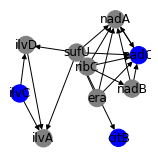

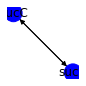

In [52]:
UG = G.to_undirected()
# extract subgraphs
sub_graphs = nx.connected_components(UG)

for i, sg in enumerate(sub_graphs):
    if not set(known_depletions) & sg: continue
    print ("subgraph {} has {} nodes".format(i, len(sg)))
    print ("\tNodes:", sg)
    SG = G.subgraph(sg)
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=2.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
    plt.savefig('figures/network_sg_{}_spoAQ.svg'.format(i),format='SVG')

## Forward interdependence clustergram

In [ ]:
d = {}
for k,v in fwd_name_dep.items():
    d[k] = {}
    for i in v:
        d[k][i] = 0

In [ ]:
kodf = pd.DataFrame.from_dict(d).fillna(1).T

In [ ]:
kodf

In [ ]:
set(confirmed_depletions) & set(kodf.index)

In [ ]:
import seaborn as sns

In [ ]:
sns.clustermap(kodf,
              figsize=(10,10))

## One gene interdependence

In [ ]:
def get_value(k):
    return list(set(fwd_name_dep[k]) - set([k]))

def traverse_graph(k,seen = set()):
    v = get_value(k)
#     print(k,v)
    if not v:
        return seen
    for i in v:
        if i in seen:continue
        seen.add(i)
        seen = traverse_graph(i,seen=seen)
    return seen

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    seen_nodes = set()
    for i in traverse_graph(gene):
        if i in seen_nodes: continue
        seen_nodes.add(i)
        dep_genes = fwd_name_dep[i]
        for j in dep_genes:
            print(i,j)
            if j==gene: continue
            G.add_edge(i,j)
    return G

In [ ]:
gene = 'argD'
G = get_graph_from_gene(gene)
G.nodes

In [ ]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in known_depletions:
        color_map.append('blue')
    else: 
        color_map.append('gray')   
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

In [ ]:
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_{}.svg'.format(gene),format='SVG')

## Histogram

In [66]:
d = {k:len(v) for k,v in fwd_name_dep.items()}

In [67]:
df = pd.DataFrame.from_dict({'influence':d})

<AxesSubplot:ylabel='Frequency'>

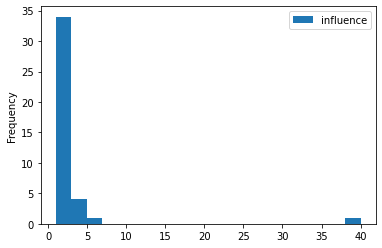

In [68]:
df.plot.hist(bins = 20)

<AxesSubplot:>

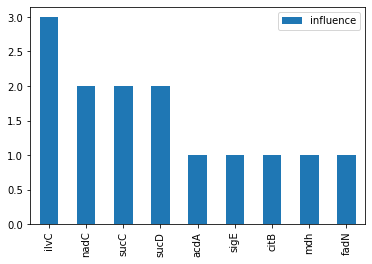

In [69]:
df1 = df.loc[[i for i in known_depletions if i in df.index]].sort_values('influence',ascending=False)
df1[df1['influence'] > 0].plot.bar()
plt.savefig('bar_blocked.svg',format='SVG')